In [16]:
import itertools
import pathlib
from pathlib import Path
from typing import Optional, List

import yaml
import dataclasses
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms

import lab.metrics
import lab.analytics

sns.set_style("white")
plt.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
})

In [25]:
@dataclasses.dataclass
class PlotConfig:
    # Each entry corresponds to an axis with the sub-dictionaries
    # storing mappings of labels to filenames 
    layout: dict
    # The path to store  
    output_files: List[pathlib.Path]
    # Line styles for the various labels
    line_styles: dict = dataclasses.field(default_factory=dict)
    # True if a legend should be added
    with_legend: bool = True
    
    @classmethod
    def from_snakemake(cls):
        return cls(
            layout=snakemake.params["layout"],
            output_files=[Path(p) for p in snakemake.output],
            line_styles=snakemake.params.get("line_styles", {}),
            with_legend=snakemake.params.get("with_legend", False),
        )
    
    def savefig(self, fig, *args, **kwargs):
        for path in self.output_files:
            if path.suffix in (".pdf", ".pgf") and "backend" not in kwargs:
                kwargs["backend"] = "pgf"
            fig.savefig(path, *args, **kwargs)
    

if "snakemake" in globals():
    config = PlotConfig.from_snakemake()
else:
    config = PlotConfig({
            "VarCNN": {
                "defended": f"../../results/ml-eval-conn/defence~front/classifier~varcnn-sizes/predictions.csv",
                "undefended": f"../../results/ml-eval-conn/defence~undefended/classifier~varcnn-sizes/predictions.csv",
                "skip-tuning": "../../predictions.csv"
            }
        },
        [Path("/tmp/plot.png")],
        line_styles={"defended": "-", "undefended": "--", "skip-tuning": ":"}
    )

In [21]:
def _load_data(inputs):
    return (
        pd.concat([
            pd.read_csv(filename, header=0).assign(title=axes_title, label=label).set_index(["title", "label"], append=True)
            for (axes_title, lines) in inputs.items()
            for (label, filename) in lines.items()
        ])
        .fillna(0)
        .rename(columns=lambda c: int(c) if c != "y_true" else c)
        .astype({"y_true": int})
        .drop(columns=[-1])
    )

data = _load_data(config.layout)
data

,,,y_true,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
,title,label,,,,,,,,,,,,,,,,,,,,,
0,VarCNN,defended,-1,2.363205e-03,4.005432e-03,1.651001e-02,1.323700e-03,3.017426e-03,9.986877e-03,1.360321e-02,1.049042e-02,2.561569e-03,...,1.565933e-03,2.323151e-03,3.301620e-03,4.070282e-03,1.102448e-02,1.823425e-02,5.516052e-03,1.502991e-03,9.231567e-03,1.801491e-03
1,VarCNN,defended,22,3.345490e-03,5.275726e-03,1.626587e-02,9.417534e-04,1.608849e-03,1.100159e-02,1.704407e-02,7.408142e-03,2.571106e-03,...,2.822876e-03,3.452301e-03,5.073547e-03,5.245209e-03,1.155090e-02,1.557159e-02,1.162720e-02,3.040314e-03,7.785797e-03,1.780510e-03
2,VarCNN,defended,25,4.890442e-03,1.204681e-02,1.039886e-02,8.262634e-03,2.026367e-02,1.582336e-02,5.226135e-03,1.505280e-02,5.867004e-03,...,4.127502e-03,1.010895e-02,6.599426e-03,6.477356e-03,8.468628e-03,1.182556e-02,5.302429e-03,2.962112e-03,1.271820e-02,7.518768e-03
3,VarCNN,defended,43,7.759094e-03,1.555634e-02,2.990723e-03,2.655029e-03,6.584167e-03,1.081085e-02,7.041931e-03,2.636719e-02,1.199341e-02,...,1.163483e-02,1.087952e-02,6.019592e-03,9.086609e-03,1.129150e-02,1.023102e-02,1.821899e-02,3.145218e-03,1.445770e-02,1.842499e-03
4,VarCNN,defended,72,2.500916e-02,1.278687e-02,4.848480e-03,5.840302e-03,2.331543e-02,7.904053e-03,4.554749e-03,2.978516e-02,1.543427e-02,...,9.941101e-03,5.233765e-03,4.859924e-03,1.861572e-02,9.902954e-03,8.956909e-03,1.229095e-02,2.471924e-03,1.479340e-02,1.408577e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,VarCNN,skip-tuning,69,1.223635e-22,1.916494e-26,2.319610e-20,8.515730e-17,1.807485e-21,4.390283e-17,7.540080e-19,6.633351e-16,4.668036e-16,...,9.840861e-14,1.701463e-11,2.329188e-19,7.627884e-11,1.067915e-19,4.304465e-09,2.080494e-25,1.897262e-17,5.296297e-25,1.143639e-21
1996,VarCNN,skip-tuning,74,7.314677e-17,8.930040e-19,5.900705e-20,8.063523e-20,1.524688e-18,7.380833e-15,2.455731e-19,5.607550e-15,1.266958e-14,...,9.178329e-11,8.296352e-04,2.119248e-14,3.075975e-18,1.170639e-11,1.694590e-13,2.836481e-16,3.060249e-15,1.285573e-18,2.221831e-17
1997,VarCNN,skip-tuning,12,2.028600e-15,1.700908e-11,6.783471e-13,3.130328e-12,1.781866e-06,1.157667e-14,2.999648e-12,7.468075e-15,6.462094e-15,...,1.554817e-16,1.212597e-19,2.384118e-12,6.935059e-16,1.816760e-09,1.200133e-14,6.334281e-14,6.851956e-18,4.267611e-10,1.845118e-14


In [22]:
data.iloc[:, 1:].idxmax(axis=1)

      title   label      
0     VarCNN  defended       72
1     VarCNN  defended       78
2     VarCNN  defended       21
3     VarCNN  defended       13
4     VarCNN  defended       10
                             ..
1995  VarCNN  skip-tuning    69
1996  VarCNN  skip-tuning    74
1997  VarCNN  skip-tuning    12
1998  VarCNN  skip-tuning    21
1999  VarCNN  skip-tuning     6
Length: 6000, dtype: int64

In [23]:
def precision_recall_curve(df):
    result = lab.analytics.rprecision_recall_curve(df["y_true"], df.drop("y_true", axis=1), ratio=20)
    return pd.DataFrame({"precision": result.precision, "recall": result.recall})

pr_scores = data.groupby(["title", "label"]).apply(lambda x: precision_recall_curve(x))
pr_scores

precision  recall
title  label                            
VarCNN defended   0     0.000571   0.012
                  1     0.000526   0.011
                  2     0.000528   0.011
                  3     0.000531   0.011
                  4     0.000538   0.011
...                          ...     ...
       undefended 240   0.000000   0.000
                  241   0.000000   0.000
                  242   0.000000   0.000
                  243   1.000000   0.000
                  244   1.000000   0.000

[597 rows x 2 columns]

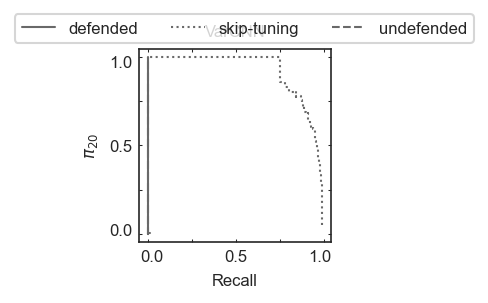

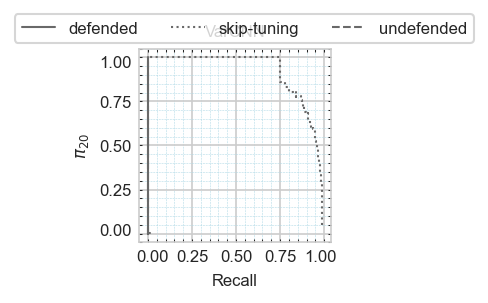

In [26]:
def plot_pr_curves(plot_data, line_styles: dict, with_legend: bool, with_grid: bool=False):
    # Create the axes for the plots
    n_plots = len(pr_scores.index.unique("title"))
    fig, axes_arr = plt.subplots(1, n_plots, figsize=(3.5, 2), sharex=True, sharey=True, dpi=150, squeeze=False)
    # Convert to a 1D array
    axes_arr = axes_arr.ravel()
    
    for (title, data), axes in zip(plot_data.groupby("title"), axes_arr):
        axes.set_title(title)
        
        for (label, data) in data.groupby("label"):
            axes.step(
                "recall", "precision", data=data, label=label, linewidth=1,
                color="dimgrey", linestyle=line_styles.get(label, "-")
            )
        axes.set_xlabel("Recall")
    
        for axis in [axes.xaxis, axes.yaxis]:
            axis.set_major_locator(ticker.FixedLocator([0, .5, 1]))
            axis.set_minor_locator(ticker.MultipleLocator(.25))
            
            if with_grid:
                axis.set_major_locator(ticker.FixedLocator([0, .25, .5, .75, 1]))
                axis.set_minor_locator(ticker.MultipleLocator(.05))
                
        axes.set_aspect("equal")
        axes.margins(0.05)
        axes.tick_params(
            axis='both', which='both', bottom=True, top=True, right=True, left=True,
            direction="in", width=.5, length = 1.5,
        )
        if with_grid:
            axes.grid(True, which="minor", axis="both", color="lightblue", linestyle="--", linewidth=.25)
            
    for axes in axes_arr:
        tick_label = axes.xaxis.get_majorticklabels()[0]
        offset = matplotlib.transforms.ScaledTranslation(2/72, 0, fig.dpi_scale_trans)
        tick_label.set_transform(tick_label.get_transform() + offset)
        
        tick_label = axes.xaxis.get_majorticklabels()[-1]
        offset = matplotlib.transforms.ScaledTranslation(-2/72, 0, fig.dpi_scale_trans)
        tick_label.set_transform(tick_label.get_transform() + offset)
        
    axes = axes_arr[0]
    tick_label = axes.yaxis.get_majorticklabels()[0]
    offset = matplotlib.transforms.ScaledTranslation(0, 2/72, fig.dpi_scale_trans)
    tick_label.set_transform(tick_label.get_transform() + offset)

    tick_label = axes.yaxis.get_majorticklabels()[-1]
    offset = matplotlib.transforms.ScaledTranslation(0, -2/72, fig.dpi_scale_trans)
    tick_label.set_transform(tick_label.get_transform() + offset)
        
    axes_arr[0].set_ylabel("$\pi_{20}$")
    axes_arr[0].yaxis.get_label().set_bbox(dict(boxstyle="square,pad=0", fc="none", ec="none"))
    handles, labels = axes_arr[0].get_legend_handles_labels()
    
    fig.tight_layout(w_pad=.25)
    fig.subplots_adjust(wspace=None, hspace=None)
    if with_legend:
        fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(.97, .85), ncol=3)
    return fig

with sns.axes_style("white"):
    fig = plot_pr_curves(pr_scores, config.line_styles, config.with_legend)
    config.savefig(fig, bbox_inches="tight", dpi=150)
    
with sns.axes_style("whitegrid"):
    fig2 = plot_pr_curves(pr_scores, config.line_styles, config.with_legend, with_grid=True)
    fig2.savefig(config.output_files[0].with_suffix(".grid.pdf"), backend="pgf", bbox_inches="tight")